
## Project: Finding Donors for *CharityML*

## Overview

In this project, we will employ several supervised algorithms of your choice to accurately model individuals' income using data collected from the 1994 U.S. Census. We will then choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. Your goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations.  Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with.  While it can be difficult to determine an individual's general income bracket directly from public sources, we can (as we will see) infer this value from other publically available features. 

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The datset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_. You can find the article by Ron Kohavi [online](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf). The data we investigate here consists of small changes to the original dataset, such as removing the `'fnlwgt'` feature and records with missing or ill-formatted entries.

----
## Exploring the Data


In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualization code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Census dataset
data = pd.read_csv("census.csv")

# Success - Display the first record
display(data.head(n=10))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53,Private,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K
5,37,Private,Masters,14.0,Married-civ-spouse,Exec-managerial,Wife,White,Female,0.0,0.0,40.0,United-States,<=50K
6,49,Private,9th,5.0,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0.0,0.0,16.0,Jamaica,<=50K
7,52,Self-emp-not-inc,HS-grad,9.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,45.0,United-States,>50K
8,31,Private,Masters,14.0,Never-married,Prof-specialty,Not-in-family,White,Female,14084.0,0.0,50.0,United-States,>50K
9,42,Private,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178.0,0.0,40.0,United-States,>50K


### Implementation: Data Exploration
A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than \$50,000. In the code cell below, you will need to compute the following:
- The total number of records, `'n_records'`
- The number of individuals making more than \$50,000 annually, `'n_greater_50k'`.
- The number of individuals making at most \$50,000 annually, `'n_at_most_50k'`.
- The percentage of individuals making more than \$50,000 annually, `'greater_percent'`.

 

In [2]:
total_population=pd.DataFrame(data)

n_records = total_population.shape[0]

# TODO: Number of records where individual's income is more than $50,000
n_greater_50k = total_population[total_population.income=='>50K'].shape[0]

# TODO: Number of records where individual's income is at most $50,000
n_at_most_50k = total_population[total_population.income=='<=50K'].shape[0]


# TODO: Percentage of individuals whose income is more than $50,000
greater_percent = (n_greater_50k*1.000)/(n_records*1.000)*100

# Print the resultsn_records
print "Total number of records: {}".format(n_records)
print "Individuals making more than $50,000: {}".format(n_greater_50k)
print "Individuals making at most $50,000: {}".format(n_at_most_50k)
print "Percentage of individuals making more than $50,000: {:.2f}%".format(greater_percent)

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78%


----
## Preparing the Data


### Transforming Skewed Continuous Features


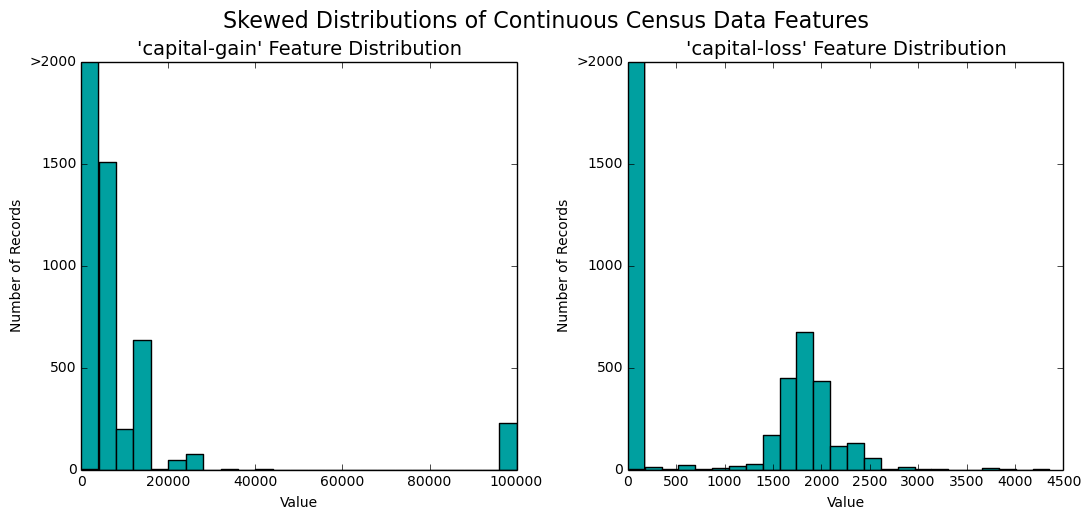

In [3]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
vs.distribution(data)

For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a <a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">logarithmic transformation</a> on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of `0` is undefined, so we must translate the values by a small amount above `0` to apply the the logarithm successfully.



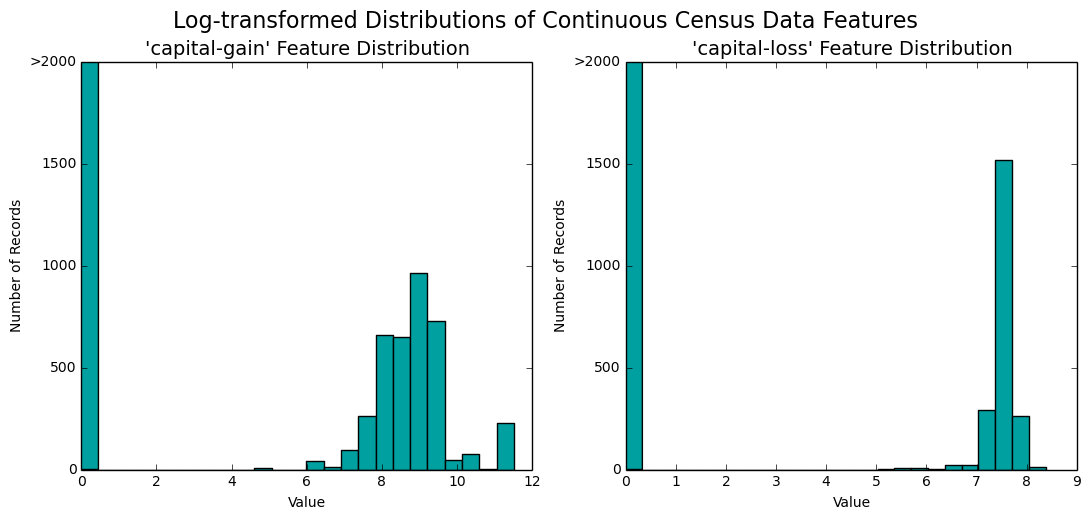

In [4]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_raw[skewed] = data[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_raw, transformed = True)

### Normalizing Numerical Features


In [5]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler()
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
features_raw[numerical] = scaler.fit_transform(data[numerical])

# Show an example of a record with scaling applied
display(features_raw.head(n = 1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.30137,State-gov,Bachelors,0.8,Never-married,Adm-clerical,Not-in-family,White,Male,0.02174,0.0,0.397959,United-States


### Data Preprocessing

.

In [6]:

pd.get_dummies(data)
features = pd.get_dummies(features_raw)



income = (income_raw == '>50K').astype(np.int)
#display(income.head(n = 10))

# Print the number of features after one-hot encoding
encoded = list(features.columns)
print "{} total features after one-hot encoding.".format(len(encoded))


print encoded

103 total features after one-hot encoding.
['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'workclass_ Federal-gov', 'workclass_ Local-gov', 'workclass_ Private', 'workclass_ Self-emp-inc', 'workclass_ Self-emp-not-inc', 'workclass_ State-gov', 'workclass_ Without-pay', 'education_level_ 10th', 'education_level_ 11th', 'education_level_ 12th', 'education_level_ 1st-4th', 'education_level_ 5th-6th', 'education_level_ 7th-8th', 'education_level_ 9th', 'education_level_ Assoc-acdm', 'education_level_ Assoc-voc', 'education_level_ Bachelors', 'education_level_ Doctorate', 'education_level_ HS-grad', 'education_level_ Masters', 'education_level_ Preschool', 'education_level_ Prof-school', 'education_level_ Some-college', 'marital-status_ Divorced', 'marital-status_ Married-AF-spouse', 'marital-status_ Married-civ-spouse', 'marital-status_ Married-spouse-absent', 'marital-status_ Never-married', 'marital-status_ Separated', 'marital-status_ Widowed', 'occupation_ A

### Shuffle and Split Data


In [7]:
# Import train_test_split
from sklearn.cross_validation import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, income, test_size = 0.2, random_state = 0)

# Show the results of the split
print "Training set has {} samples.".format(X_train.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])

Training set has 36177 samples.
Testing set has 9045 samples.


/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


----
## Evaluating Model Performance


### Question 1 - Naive Predictor Performace


In [8]:

accuracy = (n_greater_50k *1.0)/ n_records 
true_positive = n_greater_50k*1.0
true_negative = 0.0
false_positive = n_at_most_50k*1.0
false_negative=0.0

precision = true_positive / (true_positive + false_positive)

recall = true_positive / (true_positive + false_negative)
beta=0.5
fscore=(1+(beta*beta))*((precision*recall)/(((beta*beta)*precision)+recall))
# Print the results 
print "Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore)

Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]


###  Supervised Learning Models


###  Model Application
We selected three supervised learning models because

Decision Tree Classifiers

Decision tree classification is a non parametric supervised learning algorithm that maps observations about an item to conclusions about the items target value. Decision trees classifies the data using sequence of questions, the next question asked depends on answer to the current question. Decision trees can handle both numerical and categerogical data. Decisiontrees are used in face detection (https://www.researchgate.net/publication/4232792_Component-based_robust_face_detection_using_AdaBoost_and_decision_tree), detection of network intrusion (https://www.researchgate.net/publication/224377436_Network_intrusion_detection_using_feature_selection_and_Decision_tree_classifier),  digital image forgery detection(http://www.ijera.com/special_issue/Humming%20Bird_March_2014/Version%20%204/DD1823.pdf) etc.

The strengths of Decision tree are

1.Decision trees are simple to understand and interpret

2.Decision trees can handle numeric and categerogical data

3.Decision trees require less data preperation

4.Decision trees performs well on large data sets 

Weakness of Decision Trees

1.Deision trees may overfit

2.Decision trees may be unstable for small variations of data

The data given is a subset of census data and a random sample of population. The given data consists of numerical andc ategerogical  features. So I expect that  Decision trees can produce good model


SVMs

Support Vector Machines is a maximum margin classifier, it performs linear classification well with largest possible margin. It also performs non linear classification well using kernel trick. Support vector machines are used i industial applications, credit score analysis(http://www.sciencedirect.com/science/article/pii/S095741740600217X), credit rate analysis (http://www.sciencedirect.com/science/article/pii/S0167923603000861), bankrupty prediction (http://www.sciencedirect.com/science/article/pii/S095741740400096X) , hand written text recognition, etc.

Strengths of SVMs
1. Effective in high dimention spaces
2.Different kernels can be specified for decision functions
Weakness of SVMs
1. SVMs may take more time to train and predict
2. If number of features are greater than samples, SVMs may exhibit low performance

The data consists of less features compared to amount of data. The data set is not very large, So i think SVMs may perform well


Ensemble Learning(Gradient Boosting)

Ensemble learners uses multiple learning algorithms to get more performance, Ensemble learners combine many weak learners to classify data.  Ensemble learners are used in anamoly detection (http://www.ise.bgu.ac.il/faculty/liorr/EnsOfFeatureChains.pdf), Android Malware detection (http://www.academia.edu/12348488/High_Accuracy_Android_Malware_Detection_Using_Ensemble_Learning). Gradient Boosting is a type of Ensemble learner that divides the data to train weak learners and uses weighted average to model the predictor. Gradient Boosting is usedin mobile recommendation system (http://ieeexplore.ieee.org/document/7727431/), web search ranking, ecology (http://scikit-learn.org/stable/modules/ensemble.html)Biometric finger vein authentication(http://ieeexplore.ieee.org/document/7754239/) etc

Strengths of  Gradient Boosting
1. Very less chances of overfitting
2. Natural handling of mixed type of data
3.Robustness to outliers

Weakness of Gradient Boosting
1. Scalabulity due to sequential nature of boosting

The problem is a binary classification problem, the data consists of mixed type of data, since the chance of overfitting for ensemble algorithms is less, I selected Gradient Boosting algorithm 

### Implementation - Creating a Training and Predicting Pipeline


In [9]:


from sklearn.metrics import accuracy_score
from sklearn.metrics import fbeta_score
def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    
    start = time() # Get start time
    
    learner =  learner.fit(X_train.values[:sample_size, :],y_train.values[:sample_size])
    end = time() # Get end time
    train_time = end-start
    print 'Train_time :',train_time
    # TODO: Calculate the training time
    results['train_time'] = end-start
        
   
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train.values[:300, :])
    end = time() # Get end time
    pred_time = end-start
    print 'Prediction_time :',pred_time
    
    results['pred_time'] = end-start
            
   
    results['acc_train'] = accuracy_score(y_train[:300],predictions_train)
        
   
    results['acc_test'] = accuracy_score(y_test,predictions_test)
    
    
    results['f_train'] = fbeta_score(y_train[:300],predictions_train, average='macro', beta=0.5)
        
    
    results['f_test'] = fbeta_score(y_test,predictions_test, average='macro', beta=0.5)
       
   
    print "{} trained on {} samples.".format(learner.__class__.__name__, sample_size)
    
    return results

### Implementation: Initial Model Evaluation


Train_time : 0.0213677883148
Prediction_time : 0.0224249362946
DecisionTreeClassifier trained on 361 samples.
Train_time : 0.0502910614014
Prediction_time : 0.0145008563995
DecisionTreeClassifier trained on 3617 samples.
Train_time : 0.596647977829
Prediction_time : 0.0156750679016
DecisionTreeClassifier trained on 36177 samples.
Train_time : 0.0239670276642
Prediction_time : 0.376173019409
SVC trained on 361 samples.


/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Train_time : 1.61291909218
Prediction_time : 3.31453490257
SVC trained on 3617 samples.
Train_time : 164.855091095
Prediction_time : 29.7398569584
SVC trained on 36177 samples.
Train_time : 0.175153017044
Prediction_time : 0.0478060245514
GradientBoostingClassifier trained on 361 samples.
Train_time : 1.35948300362
Prediction_time : 0.0471410751343
GradientBoostingClassifier trained on 3617 samples.
Train_time : 14.9364860058
Prediction_time : 0.04749584198
GradientBoostingClassifier trained on 36177 samples.


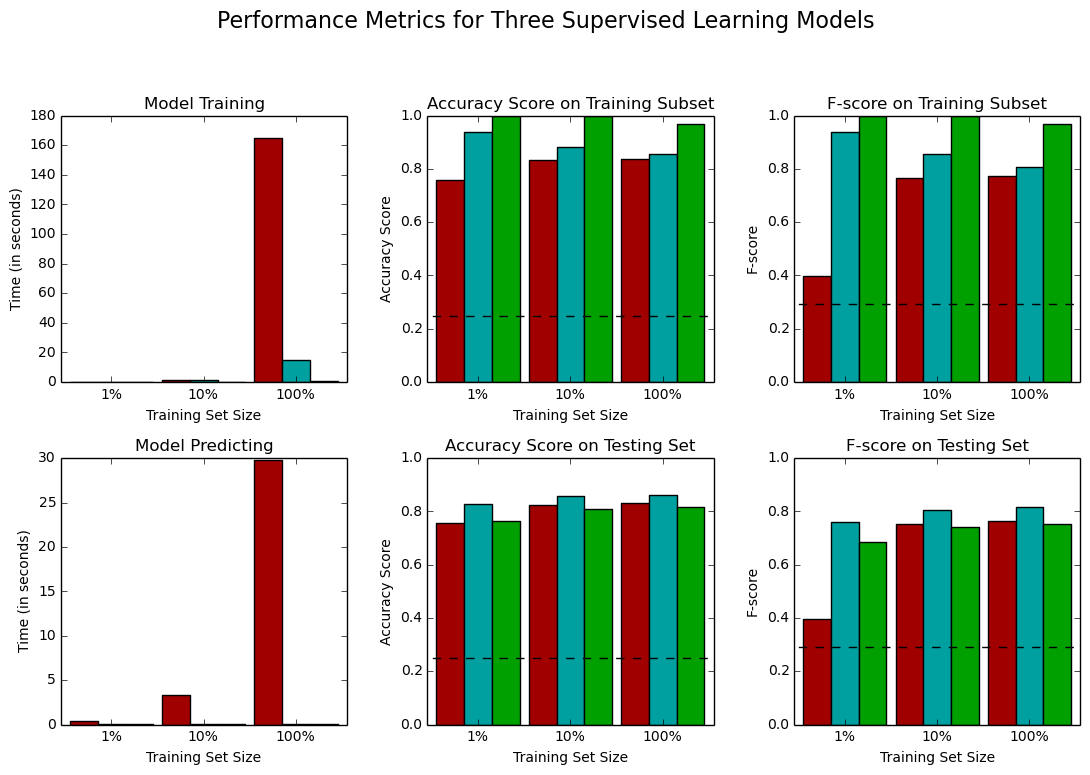

In [10]:

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn import tree

clf_A = tree.DecisionTreeClassifier(random_state=1)
clf_B = SVC(random_state=1)
clf_C = GradientBoostingClassifier(random_state=1)


samples_1 = int(0.01*X_train.shape[0])
samples_10 = int(0.1*X_train.shape[0])
samples_100 = int(X_train.shape[0])


results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)


vs.evaluate(results, accuracy, fscore)

----
## Improving Results


###  Choosing the Best Model


In above figure Green-Decision Tree, Brown-SVM, Blue-Gradient Boosting Classifier

Based on evaluation performed earlier, I believe Gradient Boosting Classifier(GBC) is appropiate for identifying individuals that make more than $50000. 

In model training decision tree classifier(DTC) taken very less time, GBC has also taken lesstime but more than DTC. But Support Vector Machines classifier(SVC) has taken much more compared to DTC and GBC.

In model prediction decision tree classifier(DTC) taken very less time, GBC has also taken very less time but slightly more than DTC. But Support Vector Machines classifier(SVC) has taken huge amountof time  compared to DTC and GBC.

DTC shown good accuracy on training set (all sizes) but less accuracy on test data(all sizes), DTC has shown signs of over fitting.

SVC shown average accuracy on training and data set. SVC may not be suitable for the data
GBC has shown good accuracy on training and test data.

DTC shown good F-Score on training set (all sizes) but low F-Score on test data(all sizes), DTC has shown signs of over fitting.

SVC shown low F-Score on less data, average F-Score on training and data set. SVC may not be suitable for the data
GBC has shown good F-Score on training and test data.

Based on above discussion DTC has shown signs of overfitting so DTC is not suitable for the data, SVC performance on training and test data is not good compared to GBC, the training and prediction time taken by SVC is also more so, SVC is not a suitable algorithm for the data. Finally, GBC has shown good performance and less training and test times so I select GBC for the given data.


###  Describing the Model in Layman's Terms



1.Gradient Boosting algorithm is an ensemble learning which take bunch of simple rules (like weather 'age'>28)  which don't perform well individually and combine those simple rule to create a complex rule that performs well on data.

2.In our case the algorithm is trained on census data. It divides the data into number of small subsets or pieces.

3.In step1, it selects a best rule that divides the data into two i.e. more than 50k and less than 50k using horizontal or vertical line.

4.One side of vertical line it classifies (>50k) and other side of line (<=50k).

5.It gives less importance or decreases importance to data points that are correctly classified  and more importance or increases importance to data points that are   misclassified.

6.In step2 it selects a rule that classifies more important points correctly using vertical or horizontal line. Again it gives less importance or decreases importance to data points that are correctly classified  and more importance or increases importance to data points that are   misclassified.

7.Finally, all the rules selected in above steps are combined to form a complex/final rule.

8.if data of individual like age, workclass, education-num etc is give the model uses the complex rule to predict weather the individual makes >50k or <=50k


### Implementation: Model Tuning


In [12]:

from sklearn.metrics import  make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

clf = GradientBoostingClassifier(random_state=1)


parameters = {'learning_rate':[0.1,0.5,1],'n_estimators':[50,100,150],'min_samples_split':[2,10,20],'max_depth':[1,3,5]}


scorer = make_scorer(fbeta_score, beta=0.5)


grid_obj = GridSearchCV(clf, parameters,cv=5, n_jobs=-1, scoring=scorer)


grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_
print grid_fit.best_estimator_
# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)
print 'Best parameters:'
print grid_fit.best_params_
print('Scores for each parameter')
display(pd.DataFrame(grid_fit.grid_scores_))

# Report the before-and-afterscores
print "Unoptimized model\n------"
print "Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5))
print "\nOptimized Model\n------"
print "Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=5,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=150, presort='auto', random_state=1,
              subsample=1.0, verbose=0, warm_start=False)
Best parameters:
{'min_samples_split': 2, 'n_estimators': 150, 'learning_rate': 0.1, 'max_depth': 5}
Scores for each parameter


/usr/local/lib/python2.7/dist-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


,parameters,mean_validation_score,cv_validation_scores
0,"{u'min_samples_split': 2, u'n_estimators': 50,...",0.708483,"[0.70534698521, 0.715860765475, 0.704768020549..."
1,"{u'min_samples_split': 2, u'n_estimators': 100...",0.723921,"[0.715575620767, 0.728934462773, 0.71956554533..."
2,"{u'min_samples_split': 2, u'n_estimators': 150...",0.728198,"[0.716302570962, 0.735531135531, 0.72641370146..."
3,"{u'min_samples_split': 10, u'n_estimators': 50...",0.708483,"[0.70534698521, 0.715860765475, 0.704768020549..."
4,"{u'min_samples_split': 10, u'n_estimators': 10...",0.723921,"[0.715575620767, 0.728934462773, 0.71956554533..."
5,"{u'min_samples_split': 10, u'n_estimators': 15...",0.728198,"[0.716302570962, 0.735531135531, 0.72641370146..."
6,"{u'min_samples_split': 20, u'n_estimators': 50...",0.708483,"[0.70534698521, 0.715860765475, 0.704768020549..."
7,"{u'min_samples_split': 20, u'n_estimators': 10...",0.723921,"[0.715575620767, 0.728934462773, 0.71956554533..."
8,"{u'min_samples_split': 20, u'n_estimators': 15...",0.728198,"[0.716302570962, 0.735531135531, 0.72641370146..."
9,"{u'min_samples_split': 2, u'n_estimators': 50,...",0.738967,"[0.73044229938, 0.753444113052, 0.731812311666..."


Unoptimized model
------
Accuracy score on testing data: 0.8630
F-score on testing data: 0.7395

Optimized Model
------
Final accuracy score on the testing data: 0.8703
Final F-score on the testing data: 0.7507


###  Final Model Evaluation


#### Results:

|     Metric     | Benchmark Predictor | Unoptimized Model | Optimized Model |
| :------------: | :-----------------: | :---------------: | :-------------: | 
| Accuracy Score |0.2478|               0.8630             |   0.8703              |
| F-score        |0.2917|               0.7395             |   0.7507      |


The accuracy of Benchmark predictor was 0.2478, unoptimized model was 0.8630 and optimized model was 0.8703. The optimized model's accuracy improved a lot compared to Benchmark predictor and slightly when compared with unoptimized model.

The F-Score of  Benchmark predictor was 0.2917 which is very poor, unoptimized model was 0.7395 (good) and optimized model was 0.7507 (good). The optimized model's F-score improved a lot compared to Benchmark predictor and reasonably well when compared with unoptimized model.

The scores of optimizad model were better.

----
## Feature Importance



###  Feature Relevance Observation


I beleive that age, education level, education num,hours-per-week, martial status are important for prediction

Justification

Age- Generally young professionals earn less and experienced professionals earn more.

education level- Mostly, Job depends on education and education level. There are chances for highly educated to earn more.

education num - There are chances for highly educated to earn more. education num is according to education level.

hours-per-week- employees working part time earn less compared to employees working full time

martial status- Generally, experienced and well earning professionals get married easily.

Ranking
1.Age  2.education level  3.education num  4.hours-per-week  5.martial status



### Implementation - Extracting Feature Importance
.

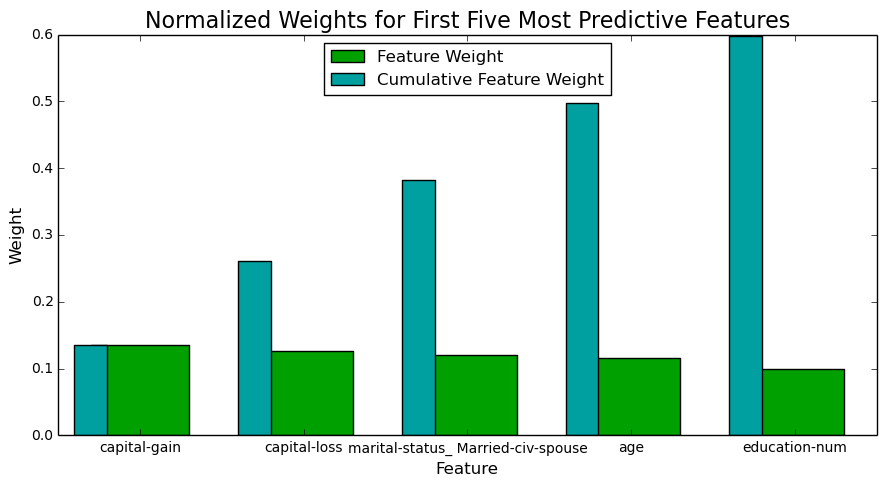

In [9]:

from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier(random_state=1)
model.fit(X_train, y_train)

importances =model.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)

###  Extracting Feature Importance



The five feature I discussed in question6 were 1.Age 2.education level 3.education num 4.hours-per-week 5.martial status. Out of five features I discussed, three features are same (Age,Education-num,martialstatus)

The visualization confirmed that younger professionals earn less and experienced professionals earn more, there are chances for highly educated to earn more and finally, experienced and well earning professionals get married easily.

### Feature Selection


In [15]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
start = time()
clf = (clone(best_clf)).fit(X_train_reduced, y_train)
end = time()
train_time= end-start
print 'Training Time :',train_time 
# Make new predictions
start1 = time()
reduced_predictions = clf.predict(X_test_reduced)
end1 = time()
pred_time= end1-start1
print 'Prediction Time :',pred_time 
# Report scores from the final model using both versions of data
print "Final Model trained on full data\n------"
print "Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))
print "\nFinal Model trained on reduced data\n------"
print "Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5))

Training Time : 4.39086508751
Prediction Time : 0.034707069397
Final Model trained on full data
------
Accuracy on testing data: 0.8697
F-score on testing data: 0.7504

Final Model trained on reduced data
------
Accuracy on testing data: 0.8583
F-score on testing data: 0.7240


###  Effects of Feature Selection


 For the given data the F-Score of model trained on all features was 0.7504 and  accuracy  was 0.8697. F-Score of model trained on only important features was 0.7240 and  accuracy  was 0.8583.The accuracy was dropped by 0.01 and F-score was dropped by 0.03 which reduced the performance of the model. The training time taken when all features are used was  14.9638090134 seconds and prediction time was 0.0501699447632 seconds. When only five important features used the training time reduced to 4.39086508751 seconds and prediction time reduced to 0.034707069397 seconds. There is a tradeoff between performance and time (prediction and training). There was less difference in prediction and training time for models trained with all features and iportant features. But there is considerable difference in performance. So, I would prefer to use model trained on all features.